In [92]:
print("hello")

hello


54.598150033144236


array([3.71989370e-48, 3.72026571e-48, 3.72063775e-48, ...,
       9.99751031e-05, 9.99851011e-05, 9.99951002e-05])

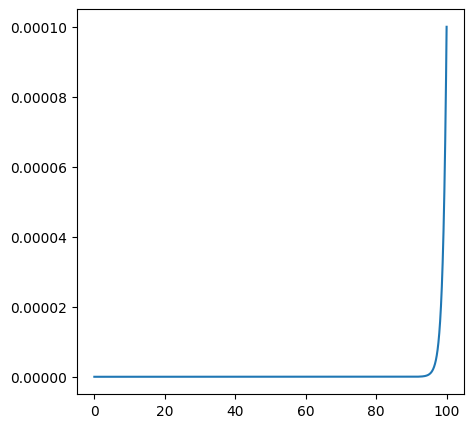

In [93]:
import numpy as np
import matplotlib.pyplot as plt

a=np.linspace(0,100, 1000000)

b=np.power(a,2)

s=np.exp(a)/np.sum(np.exp(a[:]))

plt.figure(figsize=(5,5))

plt.plot(a,s)

c=4

d= np.exp(c)

print(d)

s


In [94]:
import numpy as np

a=np.array([1,2,3,34,4,5,6,677,56,5,75,67,56,75,65432,31,2346,4])
b=a.reshape(2,9)

print(a,b)
print(a.size)
a


[    1     2     3    34     4     5     6   677    56     5    75    67
    56    75 65432    31  2346     4] [[    1     2     3    34     4     5     6   677    56]
 [    5    75    67    56    75 65432    31  2346     4]]
18


array([    1,     2,     3,    34,     4,     5,     6,   677,    56,
           5,    75,    67,    56,    75, 65432,    31,  2346,     4])

C:\Users\shams\AppData\Local\Temp\ipykernel_1516\1115627910.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt1.legend()
C:\Users\shams\AppData\Local\Temp\ipykernel_1516\1115627910.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt2.legend()
C:\Users\shams\AppData\Local\Temp\ipykernel_1516\1115627910.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt3.legend()


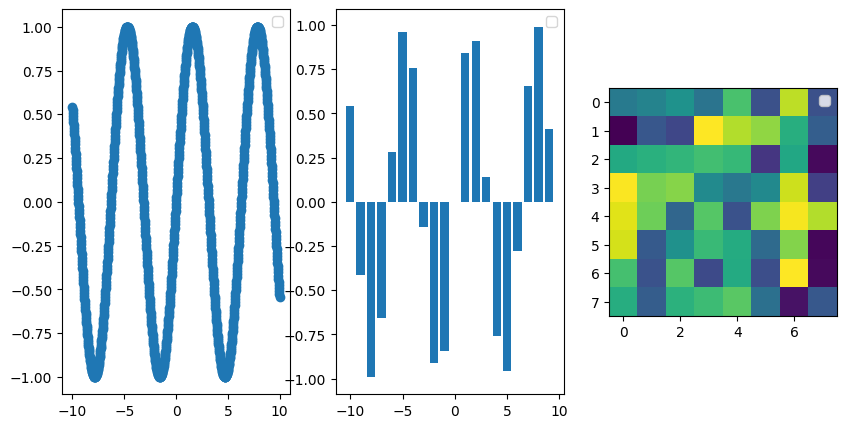

In [95]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs= plt.subplots(1, 3, figsize=(10,5))

plt1=axs[0]

x=np.linspace(-10,10, 1000)
#plt1.figure(figsize=(10,5))
plt1.scatter(x, np.sin(x))
plt1.legend()

plt2=axs[1]

x=np.arange(-10, 10, 1)
#plt2.figure(figsize=(10,5))
# plt.plot(x, np.sin(x))
plt2.bar(x, np.sin(x))
plt2.legend()

plt3=axs[2]

x=np.random.uniform(0,5,(8,8))
plt3.imshow(x)
plt3.legend()

plt.show()


In [104]:
import numpy as np

# a = np.array([0, 2, 4, 6, 8, 10])
# b = np.array([1, 3, 5, 7, 9])

# np.hsplit(a,2)

# a=np.arange(10).reshape(2,5)

# a[1]=a[1][::-1]

# a.T
# # print(a)
# # np.ravel(a)

# b=np.arange(10).reshape(5,2)
# b

# a=np.array([[1,2,3,4],
#    [5,6,7,8],
#    [9,10,11,12],
#    [13,14,15,16]])

# b=np.hstack((np.ravel(a[::2].T), np.ravel(a[1::2].T)))

# np.sum(a, axis=1)

# np.vsplit(a,2)

a=np.array([[11,2,3],
           [4,51,6]])
b=np.array([[10],
           [20]])
# np.hstack((a,b))

# np.sort(a, axis=0)

np.ravel(a.T)

a[-1, :]=a[-1,:][::-1]
a[-1, :]







#np.ravel(np.vstack((a, b)).T)



array([ 6, 51,  4])

C:\Users\shams\AppData\Local\Temp\ipykernel_7724\1520191565.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\shams\AppData\Local\Temp\ipykernel_7724\1520191565.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\shams\AppData\Local\Temp\ipykernel_7724\1520191565.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\shams\AppData\Local\Temp\ipykernel_7724\1520191565.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.l

np.float64(22026.465794806718)

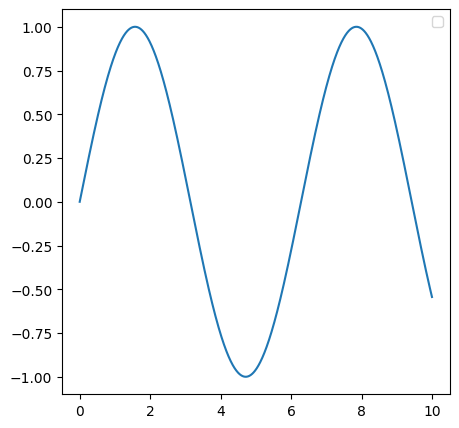

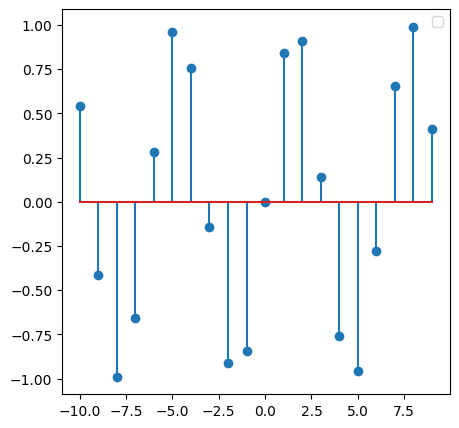

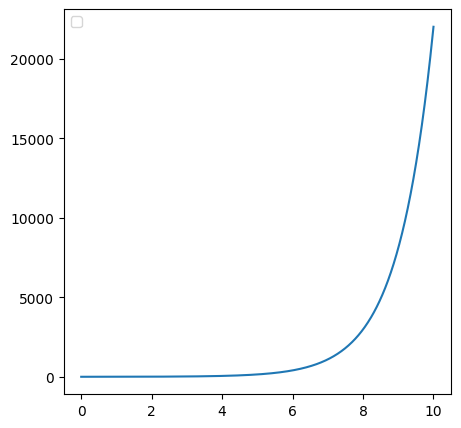

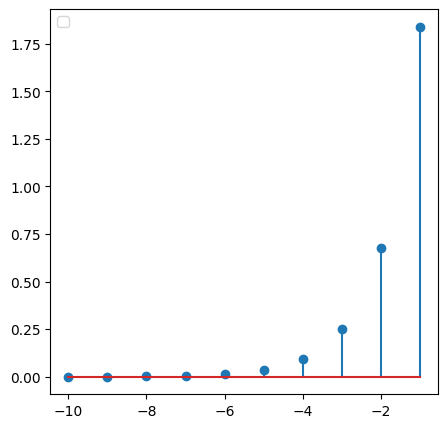

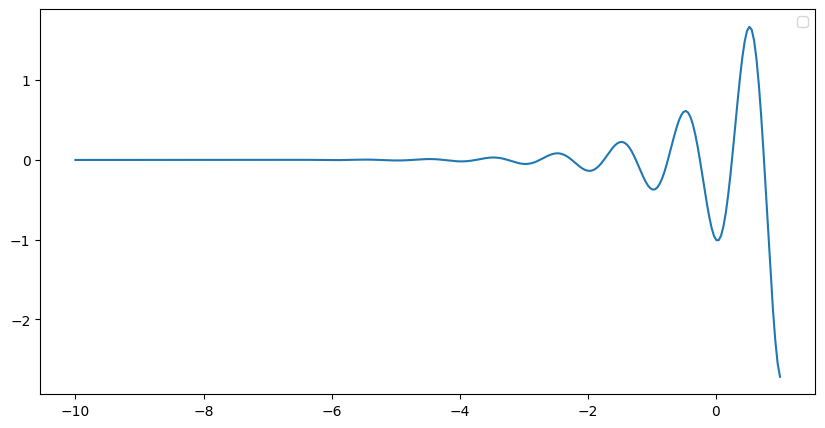

In [34]:
import numpy as np
import matplotlib.pyplot as plt

#sin curve continous

x=np.linspace(0,10, 1000)

plt.figure(figsize=(5,5))
plt.plot(x, np.sin(x))
plt.legend()

#sin curve discrete

x=np.arange(-10, 10, 1)

plt.figure(figsize=(5,5))
plt.stem(x, np.sin(x))
plt.legend()

#exp continous

x=np.linspace(0,10, 1000)

plt.figure(figsize=(5,5))
plt.plot(x, np.exp(x))
plt.legend()

#exp discrete

x=np.arange(-10, 0 , 1)

plt.figure(figsize=(5,5))
plt.stem(x, 5*np.exp(x))
plt.legend()

np.exp(10)


#exp sin

x=np.linspace(-10, 1, 300)

plt.figure(figsize=(10,5))
# plt.plot(x, np.exp(x)*np.cos(2*np.pi*x), "--")
# plt.plot(x, np.exp(x))
# plt.plot(x, -np.exp(x))


# plt.plot(x, -np.exp(x)*np.cos(2*np.pi*x), "--")


#plt.plot(x, np.exp(-x)*np.cos(-2*np.pi*x), "--")

plt.plot(x, -np.exp(x)*np.cos(2*np.pi*x))
plt.legend()

np.exp(10)








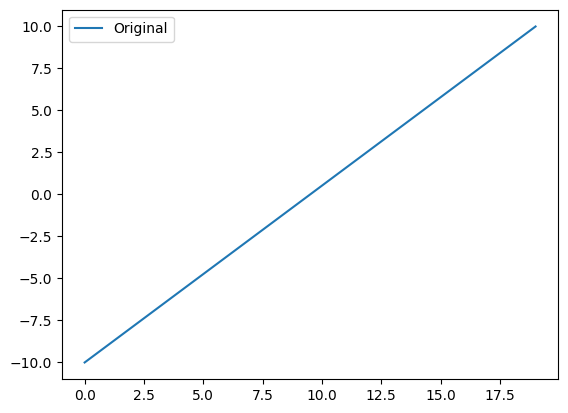

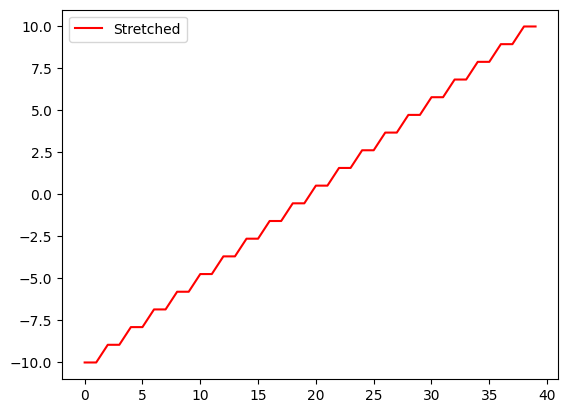

In [41]:
import numpy as np
import matplotlib.pyplot as plt

def time_stretching(x: np.ndarray, factor: int) -> np.ndarray:
    """
    Stretches the array by repeating each element, effectively slowing down the signal.
    
    Parameters:
        x (np.ndarray): Input array.
        factor (int): The stretching factor (greater than 1 stretches the array).
    
    Returns:
        np.ndarray: Stretched array.
    """
    return np.repeat(x, factor)  # Repeat each element 'factor' times

# Original data
x_val = np.arange(0, 20, 1)
x = np.linspace(-10, 10, 20)

# Plot original data
plt.figure()
plt.plot(x_val, x, label='Original')
plt.legend()

# Stretching the data
stretched_x = time_stretching(x, 2)  # Stretch by a factor of 2
stretched_x_val = np.arange(0, len(stretched_x))  # New x-values for the stretched array

# Plot stretched data
plt.figure()
plt.plot(stretched_x_val, stretched_x, label='Stretched', color='red')
plt.legend()

plt.show()


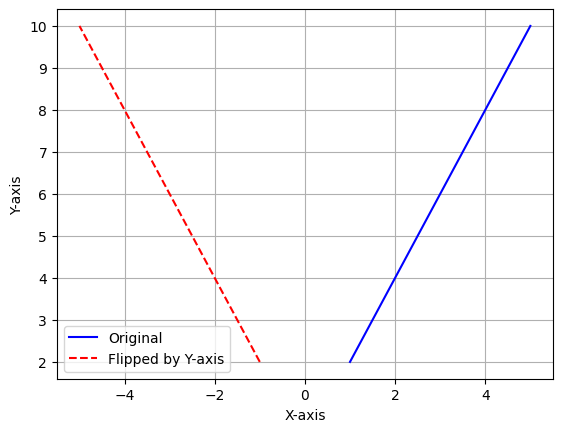

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Original data points
x = np.array([1, 2, 3, 4, 5])
y = np.array([2, 4, 6, 8, 10])

# Flip the graph along the y-axis (negate x-values)
x_flipped = -x

# Plot the original graph
plt.plot(x, y, label="Original", color='blue')

# Plot the flipped graph
plt.plot(x_flipped, y, label="Flipped by Y-axis", color='red', linestyle='--')

# Labels and legend
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
